In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
cd /gdrive

In [0]:
cd 'My Drive'/

In [0]:
cd emotion_classification/

In [0]:
!pip install googledrivedownloader

In [0]:
# Downloading the FER-2013 dataset comprising of 35887 grayscale, 48x48 sized face images 
#  with seven emotions - angry, disgusted, fearful, happy, neutral, sad and surprised.
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1X60B-uR3NtqPd4oosdotpbDgy8KOfUdr',dest_path='./data.zip',unzip=False)

In [0]:
!unzip data.zip

In [0]:
# Installing necessary libraries
!pip install tensorflow==2.1.0
!pip install numpy==1.17.4
!pip install opencv-python==4.1.2.30

In [0]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [0]:
def plot_model_history(model_history):
    # Plot Accuracy and Loss curves given the model_history
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

In [0]:
# Defining data generators
train_dir = 'data/train'
val_dir = 'data/test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = datagen_val.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

In [0]:
# Create CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [0]:
# Training
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit_generator(train_generator,steps_per_epoch=num_train // batch_size,epochs=num_epoch,validation_data=validation_generator,validation_steps=num_val // batch_size)
model.save_weights('model.h5')
plot_model_history(model_info)

In [0]:
# Loading model weights
model.load_weights('model.h5')

In [0]:
# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

# dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# start the webcam feed
cap = cv2.VideoCapture(0)
while True:
# Using Haar cascade to draw bounding box around the face
  ret, frame = cap.read()
  if not ret:
    break
  facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

  for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    prediction = model.predict(cropped_img)
    maxindex = int(np.argmax(prediction))
    cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

  cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [19]:
ls

data/     haarcascade_frontalface_default.xml  plot.png  test_images/
data.zip  model.h5                             results/


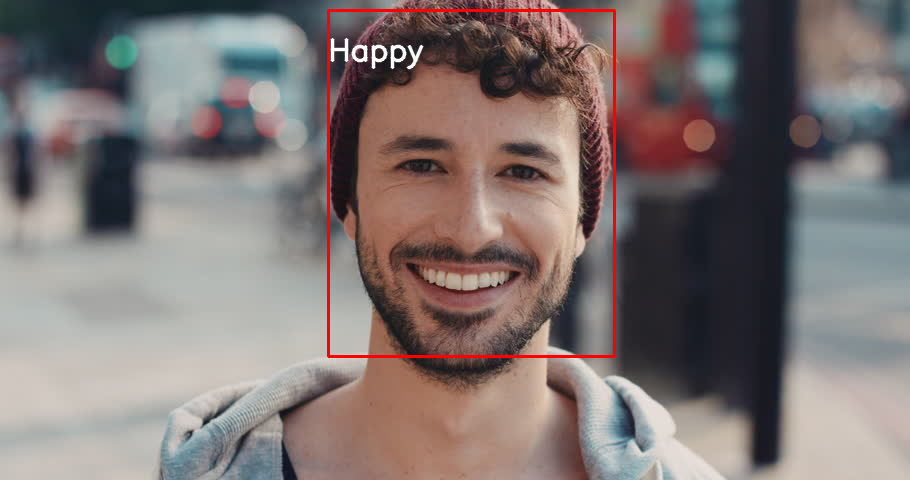

True

In [33]:
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
# Running an image example
img = cv2.imread("test_images/happy_3.jpg")
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)
for (x, y, w, h) in faces:
  cv2.rectangle(img, (x, y-50), (x+w, y+h+10), (0, 0, 255), 2)
  roi_gray = gray[y:y + h, x:x + w]
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = model.predict(cropped_img)
  maxindex = int(np.argmax(prediction))
  cv2.putText(img, emotion_dict[maxindex], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
cv2_imshow(img)
cv2.imwrite("results/happy_3_result.jpg",img)